# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record



### Questions:
1. Which demographic groups respond best to which offer type?
2. What are the top 5 features that influence those offer reactions?

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split

In [2]:
# read data in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# EDA (Exploratory data analysis) 


Take a look for those three data sets

In [3]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [4]:
portfolio.shape

(10, 6)

In [5]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [6]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [7]:
profile.shape

(17000, 5)

In [8]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [9]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [10]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [11]:
transcript.shape

(306534, 4)

In [12]:
# Unify the name for all the id columns to proper name in those three data sets

portfolio.rename(columns={"id":"offer_id"}, inplace=True)
profile.rename(columns={"id":"customer_id"}, inplace=True)
transcript.rename(columns={"person":"customer_id"}, inplace=True)

In [13]:
# make copy of those dataframe just in case

offer = portfolio.copy()
customer = profile.copy()
transaction = transcript.copy()

### Data Cleaning:

### Offer Dataset

one hot encoding for channels and offer_type columns

In [14]:
offer.head()

,channels,difficulty,duration,offer_id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [15]:
# process channels columns
# finding all the channels

channels = []
for channel in offer.channels:
    for i in channel:
        if i not in channels:
            channels.append(i)
            
print(channels)            

['email', 'mobile', 'social', 'web']


In [16]:
# add those channel names as columns with one hot encoding

for i in channels:
    offer[i] = offer['channels'].apply(lambda x: 1 if i in x else 0)

offer.head()

,channels,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


In [17]:
# add offer type names as columns with one hot encoding

offer = pd.concat([offer, pd.get_dummies(portfolio['offer_type'])],axis=1)
offer.head()

,channels,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web,bogo,discount,informational
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,1,0,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,1,0,0
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1,0,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,1,0,0
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1,0,1,0


In [18]:
# drop the useless channels column

offer.drop(['channels'],axis=1,inplace=True)
offer.head()

,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web,bogo,discount,informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1,0,1,0


### Customer Dataset

In [19]:
customer.head()

,age,became_member_on,gender,customer_id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [20]:
print("Number of unique customers in customer dataset:", customer.customer_id.nunique())
print("Number of unique customers in transaction dataset:", transaction.customer_id.nunique())

Number of unique customers in customer dataset: 17000
Number of unique customers in transaction dataset: 17000


Since the number of unique customers in customer dataset is same in transaction dataset, it is not a good idea to delete the record with null value in customer dataset. In order to make the best usage of customer dataset, I will fill null with NA in gender column and  null with mean value of income column. 

In [21]:
# fill null with NA in gender column 
customer['gender'].fillna('NA', inplace=True)
customer.head()

,age,became_member_on,gender,customer_id,income
0,118,20170212,NA,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,NA,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,NA,a03223e636434f42ac4c3df47e8bac43,NaN


In [22]:
# change became_member_on column to datetime format for future usage
customer.became_member_on = customer.became_member_on.apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
customer.head()

,age,became_member_on,gender,customer_id,income
0,118,2017-02-12,NA,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,2018-07-12,NA,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,2017-08-04,NA,a03223e636434f42ac4c3df47e8bac43,NaN


In [23]:
# fill null with mean value of income column
customer['income'].fillna((customer['income'].mean()), inplace=True)
customer.head()

,age,became_member_on,gender,customer_id,income
0,118,2017-02-12,NA,68be06ca386d4c31939f3a4f0e3dd783,65404.991568
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.000000
2,118,2018-07-12,NA,38fe809add3b4fcf9315a9694bb96ff5,65404.991568
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.000000
4,118,2017-08-04,NA,a03223e636434f42ac4c3df47e8bac43,65404.991568


C:\Users\wangs\Anaconda3\lib\site-packages\pandas\core\series.py:850: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


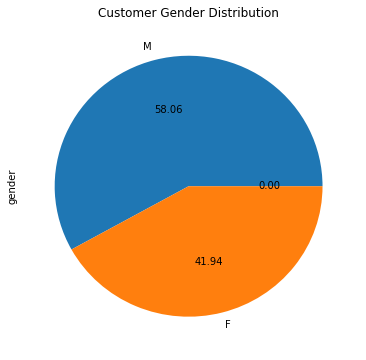

In [24]:
# Customer Gender Distrubution
customer.gender.value_counts()[['M','F','0']].plot(kind='pie', autopct='%.2f', figsize=(6,6));
plt.title('Customer Gender Distribution')
plt.show();

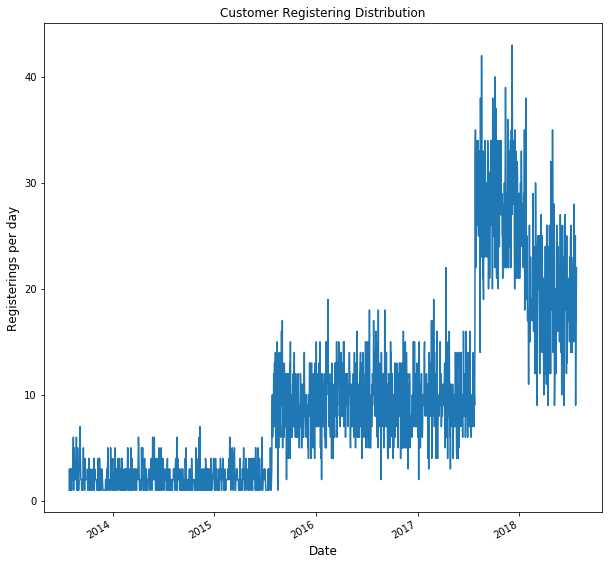

In [25]:
# Customer Registering Distrubution
customer.became_member_on.value_counts().plot(kind = 'line', figsize = (10,10))
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Registerings per day', fontsize = 12)
plt.title('Customer Registering Distribution')
plt.show();

### Transaction Dataset

In [26]:
transaction.head()

,event,customer_id,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [27]:
# Expend value column's dictionaries to new columns

transaction  = pd.concat([transaction, transaction['value'].apply(pd.Series)],axis=1)
transaction.head()

,event,customer_id,time,value,offer id,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [28]:
# Notice 'offer id' column and offer_id column are both for offer id. It's time to combine them together
transaction.offer_id.fillna(transaction['offer id'], inplace=True)
transaction.head()

,event,customer_id,time,value,offer id,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [29]:
# one hot encoding for event column
transaction = pd.concat([transaction, pd.get_dummies(transaction['event'])],axis=1)
transaction.head()

,event,customer_id,time,value,offer id,amount,offer_id,reward,offer completed,offer received,offer viewed,transaction
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,0,1,0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,0,1,0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,0,1,0,0


In [30]:
# drop useless event, offer id and value columns
transaction.drop(['event','offer id','value'],axis = 1,inplace=True)
transaction.head()

,customer_id,time,amount,offer_id,reward,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,0,1,0,0


In [31]:
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 9 columns):
customer_id        306534 non-null object
time               306534 non-null int64
amount             138953 non-null float64
offer_id           167581 non-null object
reward             33579 non-null float64
offer completed    306534 non-null uint8
offer received     306534 non-null uint8
offer viewed       306534 non-null uint8
transaction        306534 non-null uint8
dtypes: float64(2), int64(1), object(2), uint8(4)
memory usage: 12.9+ MB


# Data Analyzing

1.	To determine which demographic groups respond best to which offer type?

In [32]:
# merge customer, transaction and offer datasets
transaction_customer = pd.merge(transaction, customer, how='left', on='customer_id')
transaction_customer_offer = pd.merge(transaction_customer,offer, how='left', on='offer_id')
transaction_customer_offer.head()

,customer_id,time,amount,offer_id,reward_x,offer completed,offer received,offer viewed,transaction,age,...,duration,offer_type,reward_y,email,mobile,social,web,bogo,discount,informational
0,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0,75,...,7.0,bogo,5.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1,0,0,118,...,10.0,discount,5.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,0,1,0,0,68,...,7.0,discount,2.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,0,1,0,0,118,...,10.0,discount,2.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
4,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,0,1,0,0,118,...,5.0,bogo,10.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


In [33]:
transaction_customer_offer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 24 columns):
customer_id         306534 non-null object
time                306534 non-null int64
amount              138953 non-null float64
offer_id            167581 non-null object
reward_x            33579 non-null float64
offer completed     306534 non-null uint8
offer received      306534 non-null uint8
offer viewed        306534 non-null uint8
transaction         306534 non-null uint8
age                 306534 non-null int64
became_member_on    306534 non-null datetime64[ns]
gender              306534 non-null object
income              306534 non-null float64
difficulty          167581 non-null float64
duration            167581 non-null float64
offer_type          167581 non-null object
reward_y            167581 non-null float64
email               167581 non-null float64
mobile              167581 non-null float64
social              167581 non-null float64
web                

### BOGO

In [34]:
# filter out BOGO offer data
bogo = transaction_customer_offer[transaction_customer_offer.bogo ==1]
bogo.head()

,customer_id,time,amount,offer_id,reward_x,offer completed,offer received,offer viewed,transaction,age,...,duration,offer_type,reward_y,email,mobile,social,web,bogo,discount,informational
0,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0,75,...,7.0,bogo,5.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
4,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,0,1,0,0,118,...,5.0,bogo,10.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
5,389bc3fa690240e798340f5a15918d5c,0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN,0,1,0,0,65,...,5.0,bogo,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
12,4b0da7e80e5945209a1fdddfe813dbe0,0,NaN,ae264e3637204a6fb9bb56bc8210ddfd,NaN,0,1,0,0,64,...,7.0,bogo,10.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
18,ebe7ef46ea6f4963a7dd49f501b26779,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0,59,...,7.0,bogo,5.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0


In [35]:
# calculate offer view ratio and complete ratio
received_number = bogo[bogo['offer received']== 1].shape[0]
print('Offer viewed rate : {0:.2%}'.format(bogo['offer viewed'].value_counts()[1]/received_number))
print('Offer completed rate ：{0:.2%}'.format(bogo['offer completed'].value_counts()[1]/received_number))

Offer viewed rate : 83.44%
Offer completed rate ：51.38%


#### Offer viewed group demograhpic analyzing

In [36]:
# calculate offer viewed group demograhpic data
bogo_viewed = bogo[bogo['offer viewed'] == 1]
print('BOGO offer viewed average age :', round(bogo_viewed['age'].mean(),2))
print('BOGO offer viewed male ratio :  {0:.2%}'.format(bogo_viewed['gender'].value_counts()[0]/bogo_viewed['gender'].shape[0]))
print('BOGO offer viewed female ratio :  {0:.2%}'.format(bogo_viewed['gender'].value_counts()[1]/bogo_viewed['gender'].shape[0]))
print('BOGO offer viewed average income :', round(bogo_viewed['income'].mean(),2))

BOGO offer viewed average age : 62.9
BOGO offer viewed male ratio :  49.44%
BOGO offer viewed female ratio :  35.93%
BOGO offer viewed average income : 65424.77


#### Offer completed group demograhpic analyzing

In [37]:
# calculate offer completed group demograhpic data
bogo_completed = bogo[bogo['offer completed'] == 1]
print('BOGO offer completed average age :', round(bogo_completed['age'].mean(),2))
print('BOGO offer completed male ratio : {0:.2%}'.format(bogo_completed['gender'].value_counts()[0]/bogo_completed['gender'].shape[0]))
print('BOGO offer completed female ratio : {0:.2%}'.format(bogo_completed['gender'].value_counts()[1]/bogo_completed['gender'].shape[0]))
print('BOGO offer completed average income :', round(bogo_completed['income'].mean(),2))

BOGO offer completed average age : 57.7
BOGO offer completed male ratio : 47.94%
BOGO offer completed female ratio : 47.87%
BOGO offer completed average income : 70095.76


### Discount

In [38]:
# filter out discount offer data
discount = transaction_customer_offer[transaction_customer_offer.discount ==1]
discount.head()

,customer_id,time,amount,offer_id,reward_x,offer completed,offer received,offer viewed,transaction,age,...,duration,offer_type,reward_y,email,mobile,social,web,bogo,discount,informational
1,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1,0,0,118,...,10.0,discount,5.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,0,1,0,0,68,...,7.0,discount,2.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,0,1,0,0,118,...,10.0,discount,2.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
6,c4863c7985cf408faee930f111475da3,0,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,0,1,0,0,118,...,7.0,discount,3.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
8,aa4862eba776480b8bb9c68455b8c2e1,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1,0,0,61,...,10.0,discount,5.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [39]:
# calculate offer view ratio and complete ratio
received_number = discount[discount['offer received']== 1].shape[0]
print('Offer viewed rate : {0:.2%}'.format( discount['offer viewed'].value_counts()[1]/received_number))
print('Offer completed rate : {0:.2%}'.format(discount['offer completed'].value_counts()[1]/received_number))

Offer viewed rate : 70.21%
Offer completed rate : 58.64%


#### Offer viewed group demograhpic analyzing

In [40]:
# calculate offer viewed group demograhpic data
discount_viewed = discount[discount['offer viewed'] == 1]
print('BOGO offer viewed average age :', round(discount_viewed['age'].mean(),2))
print('BOGO offer viewed male ratio :  {0:.2%}'.format(discount_viewed['gender'].value_counts()[0]/discount_viewed['gender'].shape[0]))
print('BOGO offer viewed female ratio :  {0:.2%}'.format(discount_viewed['gender'].value_counts()[1]/discount_viewed['gender'].shape[0]))
print('BOGO offer viewed average income :', round(discount_viewed['income'].mean(),2))

BOGO offer viewed average age : 63.73
BOGO offer viewed male ratio :  48.64%
BOGO offer viewed female ratio :  36.06%
BOGO offer viewed average income : 66328.02


#### Offer completed group demograhpic analyzing

In [41]:
# calculate offer completed group demograhpic data
discount_completed = discount[discount['offer completed'] == 1]
print('BOGO offer completed average age :', round(discount_completed['age'].mean(),2))
print('BOGO offer completed male ratio : {0:.2%}'.format(discount_completed['gender'].value_counts()[0]/discount_completed['gender'].shape[0]))
print('BOGO offer completed female ratio : {0:.2%}'.format(discount_completed['gender'].value_counts()[1]/discount_completed['gender'].shape[0]))
print('BOGO offer completed average income :', round(discount_completed['income'].mean(),2))

BOGO offer completed average age : 58.12
BOGO offer completed male ratio : 49.99%
BOGO offer completed female ratio : 44.53%
BOGO offer completed average income : 68593.93


### informational       

In [42]:
# filter out informational offer data
informational = transaction_customer_offer[transaction_customer_offer.informational ==1]
informational.head()

,customer_id,time,amount,offer_id,reward_x,offer completed,offer received,offer viewed,transaction,age,...,duration,offer_type,reward_y,email,mobile,social,web,bogo,discount,informational
7,2eeac8d8feae4a8cad5a6af0499a211d,0,NaN,3f207df678b143eea3cee63160fa8bed,NaN,0,1,0,0,58,...,4.0,informational,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
13,c27e0d6ab72c455a8bb66d980963de60,0,NaN,3f207df678b143eea3cee63160fa8bed,NaN,0,1,0,0,78,...,4.0,informational,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
31,be8a5d1981a2458d90b255ddc7e0d174,0,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,0,1,0,0,39,...,3.0,informational,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
44,a5a6ef2b78a04ddc9f374dd7c7f60bff,0,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,0,1,0,0,75,...,3.0,informational,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
53,6e04a90a0e074496b5f229eb1f553433,0,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,0,1,0,0,27,...,3.0,informational,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0


In [43]:
# calculate offer view ratio and complete ratio
received_number = informational[informational['offer received']== 1].shape[0]
print('Offer viewed rate : {0:.2%}'.format(informational['offer viewed'].value_counts()[1]/received_number))

Offer viewed rate : 71.09%


#### Offer viewed group demograhpic analyzing

In [44]:
# calculate offer viewed group demograhpic data
informational_viewed = informational[informational['offer viewed'] == 1]
print('BOGO offer viewed average age :', round(informational_viewed['age'].mean(),2))
print('BOGO offer viewed male ratio :  {0:.2%}'.format(informational_viewed['gender'].value_counts()[0]/informational_viewed['gender'].shape[0]))
print('BOGO offer viewed female ratio :  {0:.2%}'.format(informational_viewed['gender'].value_counts()[1]/informational_viewed['gender'].shape[0]))
print('BOGO offer viewed average income :', round(informational_viewed['income'].mean(),2))

BOGO offer viewed average age : 63.25
BOGO offer viewed male ratio :  48.83%
BOGO offer viewed female ratio :  36.10%
BOGO offer viewed average income : 65540.83


### Overall

In [45]:
# filter out the offer viewed and offer completed data
offer_viewed = transaction_customer_offer[transaction_customer_offer['offer viewed']==1]
offer_completed = transaction_customer_offer[transaction_customer_offer['offer completed']==1]

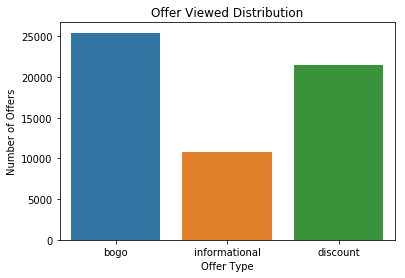

In [46]:
# plotting viewed offer distrubution
sns.countplot(x='offer_type', data=offer_viewed)

plt.title('Offer Viewed Distribution')
plt.ylabel('Number of Offers')
plt.xlabel('Offer Type')
plt.xticks(rotation = 0)
plt.show();

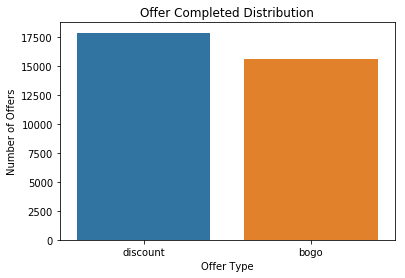

In [47]:
# plotting completed offer distrubution
sns.countplot(x='offer_type', data=offer_completed)

plt.title('Offer Completed Distribution')
plt.ylabel('Number of Offers')
plt.xlabel('Offer Type')
plt.xticks(rotation = 0)
plt.show();

# Machine Learning Process

In [48]:
# inner merge customer, transaction and offer datasets to reduce null value
df = pd.merge(transaction, customer, how='inner', on='customer_id')
df = pd.merge(df,offer, how='inner', on='offer_id')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167581 entries, 0 to 167580
Data columns (total 24 columns):
customer_id         167581 non-null object
time                167581 non-null int64
amount              0 non-null float64
offer_id            167581 non-null object
reward_x            33579 non-null float64
offer completed     167581 non-null uint8
offer received      167581 non-null uint8
offer viewed        167581 non-null uint8
transaction         167581 non-null uint8
age                 167581 non-null int64
became_member_on    167581 non-null datetime64[ns]
gender              167581 non-null object
income              167581 non-null float64
difficulty          167581 non-null int64
duration            167581 non-null int64
offer_type          167581 non-null object
reward_y            167581 non-null int64
email               167581 non-null int64
mobile              167581 non-null int64
social              167581 non-null int64
web                 167581 non-null 

In [49]:
# drop useless columns for the ML process
df.drop(['amount', 'reward_x', 'customer_id', 'offer_id', 'offer_type', 'became_member_on'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167581 entries, 0 to 167580
Data columns (total 18 columns):
time               167581 non-null int64
offer completed    167581 non-null uint8
offer received     167581 non-null uint8
offer viewed       167581 non-null uint8
transaction        167581 non-null uint8
age                167581 non-null int64
gender             167581 non-null object
income             167581 non-null float64
difficulty         167581 non-null int64
duration           167581 non-null int64
reward_y           167581 non-null int64
email              167581 non-null int64
mobile             167581 non-null int64
social             167581 non-null int64
web                167581 non-null int64
bogo               167581 non-null uint8
discount           167581 non-null uint8
informational      167581 non-null uint8
dtypes: float64(1), int64(9), object(1), uint8(7)
memory usage: 16.5+ MB


In [50]:
# One Hot Encoding for gender column
df = pd.concat([df, pd.get_dummies(df['gender'])],axis=1)
df.drop(['gender'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167581 entries, 0 to 167580
Data columns (total 21 columns):
time               167581 non-null int64
offer completed    167581 non-null uint8
offer received     167581 non-null uint8
offer viewed       167581 non-null uint8
transaction        167581 non-null uint8
age                167581 non-null int64
income             167581 non-null float64
difficulty         167581 non-null int64
duration           167581 non-null int64
reward_y           167581 non-null int64
email              167581 non-null int64
mobile             167581 non-null int64
social             167581 non-null int64
web                167581 non-null int64
bogo               167581 non-null uint8
discount           167581 non-null uint8
informational      167581 non-null uint8
F                  167581 non-null uint8
M                  167581 non-null uint8
NA                 167581 non-null uint8
O                  167581 non-null uint8
dtypes: float64(1), int64(

### Modeling with target of view

In [51]:
# Extract features and labels
y = df['offer viewed']
X = df.drop(['offer viewed', 'offer completed', 'offer received'], axis=1)

In [52]:
#train test split
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state = 8)

In [53]:
# Modeling
rf_view = RandomForestClassifier() 

#fitting the model
rf_view.fit(train_X, train_y)

#Socore the result
rf_view.score(test_X, test_y)

0.6413022722932977

In [54]:
# Analisys of important features
view_feature_importances = pd.DataFrame(rf_view.feature_importances_,
                                   index = train_X.columns,
                                columns=['importance']).sort_values('importance',ascending=False)
view_feature_importances

,importance
time,0.541506
age,0.220028
income,0.201933
social,0.011834
duration,0.005252
difficulty,0.003133
mobile,0.002950
reward_y,0.002642
NA,0.002619
informational,0.001891


In [55]:
# top 5 influencers
view_feature_importances.head(5)

,importance
time,0.541506
age,0.220028
income,0.201933
social,0.011834
duration,0.005252


### Modeling with target of completed

In [56]:
# Extract features and labels
y = df['offer completed']
X = df.drop(['offer viewed', 'offer completed', 'offer received'], axis=1)

In [57]:
#train test split
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state = 8)

In [58]:
# Modeling
rf_completed = RandomForestClassifier() 

#fitting the model
rf_completed.fit(train_X, train_y)

#Socore the result
rf_completed.score(test_X, test_y)

0.7734389917891923

In [59]:
# Analisys of important features
completed_feature_importances = pd.DataFrame(rf_completed.feature_importances_,
                                   index = train_X.columns,
                                columns=['importance']).sort_values('importance',ascending=False)
completed_feature_importances

,importance
time,0.527017
age,0.200954
income,0.194774
difficulty,0.016580
reward_y,0.014032
duration,0.013943
NA,0.010908
informational,0.009912
F,0.004597
social,0.001756


In [60]:
# top 5 influencers
completed_feature_importances.head(5)

,importance
time,0.527017
age,0.200954
income,0.194774
difficulty,0.016580
reward_y,0.014032


dig deeper on 'time', 'age' and 'income'

In [61]:
df.time.describe()

count    167581.000000
mean        353.778412
std         198.301287
min           0.000000
25%         168.000000
50%         408.000000
75%         510.000000
max         714.000000
Name: time, dtype: float64

In [62]:
df.age.describe()

count    167581.000000
mean         61.862616
std          25.693155
min          18.000000
25%          45.000000
50%          58.000000
75%          72.000000
max         118.000000
Name: age, dtype: float64

In [63]:
df.income.describe()

count    167581.000000
mean      66301.055142
std       20259.401992
min       30000.000000
25%       52000.000000
50%       65404.991568
75%       78000.000000
max      120000.000000
Name: income, dtype: float64